### PuLP 

Objective Value: 105.0


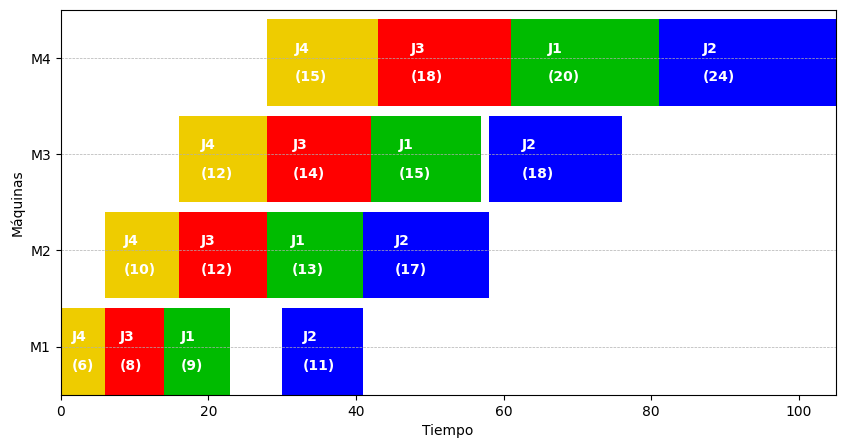

In [13]:
import pulp as lp
import numpy as np
import matplotlib.pyplot as plt

T = np.array([[9, 13, 15, 20],
              [11, 17, 18, 24],
              [8, 12, 14, 18],
              [6, 10, 12, 15]])

T = T.transpose()

# Crear el problema de minimización
model = lp.LpProblem("Wagner_Model", lp.LpMinimize)

N = len(T[0])  # Numero de tareas
M = len(T)     # Numero de maquinas

# Definir las variables
Z = lp.LpVariable.dicts("Z", (range(N), range(N)), cat='Binary')
X = lp.LpVariable.dicts("X", (range(M), range(N)), lowBound=0, cat='Integer')
Y = lp.LpVariable.dicts("Y", (range(M), range(N)), lowBound=0, cat='Integer')

# Definir la función objetivo
model += lp.lpSum(T[M - 1][i] for i in range(N)) + \
         lp.lpSum(X[M - 1][p] for p in range(N))

# Definir las restricciones
for i in range(N):
    model += lp.lpSum(Z[i][j] for j in range(N)) == 1
    
for j in range(N):
    model += lp.lpSum(Z[i][j] for i in range(N)) == 1

for r in range(M - 1):
    for j in range(N - 1):
        model += lp.lpSum(T[r][i] * Z[i][j + 1] for i in range(N)) - \
                 lp.lpSum(T[r + 1][i] * Z[i][j] for i in range(N)) + \
                 X[r][j + 1] - X[r + 1][j + 1] + Y[r][j + 1] - Y[r][j] == 0

for r in range(M - 1):
    model += lp.lpSum(T[r][i] * Z[i][0] for i in range(N)) +  X[r][0] - X[r + 1][0] + Y[r][0] == 0

# Resolver el problema
solution = model.solve()

# Imprimir la solución
print("Objective Value:", lp.value(model.objective))
 
# Carta Gannt
# Determinar el orden de las tareas
unos_tareas = [(i, j) for i in range(N) for j in range(N) if Z[i][j].varValue == 1]
orden_tareas = [tupla[0] for tupla in sorted(unos_tareas, key=lambda x: x[1])]

# Matriz de tiempos
matriz = []
for r in range(M):
    maquina = []
    for j in range(N):
        if(j == 0):
            maquina.append([int(X[r][j].varValue), int(X[r][j].varValue) + T[r][orden_tareas[j]]])
        else:
            maquina.append([maquina[-1][1]+int(X[r][j].varValue), maquina[-1][1] + int(X[r][j].varValue) + T[r][orden_tareas[j]]])
    matriz.append(maquina)

# Graficar la carta de Gantt
fig, gantt = plt.subplots(figsize=(10, 5))
gantt.set_xlabel('Tiempo')
gantt.set_ylabel('Máquinas')
gantt.set_xlim(0, lp.value(model.objective))
gantt.set_ylim(0, M * 10)
gantt.set_yticks(np.arange(5, M * 10, 10))
gantt.set_yticklabels(['M' + str(i) for i in range(1, M+1)])
gantt.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)
colores = ['#00BB00', 'blue', 'red', '#EECC00']

for r in range(M):
    for j in range(N):
        inicio = matriz[r][j][0]
        duracion = matriz[r][j][1] - matriz[r][j][0]
        gantt.broken_barh([(inicio, duracion)], ((r) * 10, 9), facecolors=colores[orden_tareas[j]])
        gantt.text(x=(inicio + duracion/4), y=((r) * 10 + 6), s='J'+str(orden_tareas[j]+1), va='center', color='white', fontweight='bold')
        gantt.text(x=(inicio + duracion/4), y=((r) * 10 + 3), s='('+str(duracion)+')', va='center', color='white', fontweight='bold')

### CPLEX

Objective Value: 105.0


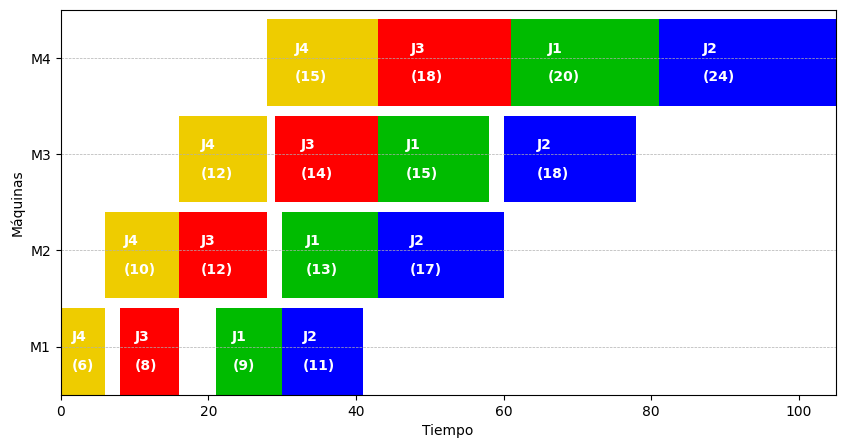

In [16]:
from docplex.mp.model import Model
import matplotlib.pyplot as plt
import numpy as np

T = np.array([[9, 13, 15, 20],
              [11, 17, 18, 24],
              [8, 12, 14, 18],
              [6, 10, 12, 15]])

T = T.transpose()

# Crear el modelo
model = Model(name="Wagner_Model")

N = len(T[0])  # Numero de tareas
M = len(T)     # Numero de maquinas

# Definir las variables
Z = {(i, j): model.binary_var(name=f"Z_{i}_{j}") for i in range(N) for j in range(N)}
X = {(r, j): model.integer_var(name=f"X_{r}_{j}", lb=0) for r in range(M) for j in range(N)}
Y = {(r, j): model.integer_var(name=f"Y_{r}_{j}", lb=0) for r in range(M) for j in range(N)}

# Definir la función objetivo
model.minimize(model.sum(T[M-1][i] for i in range(N)) +
               model.sum(X[M-1,p] for p in range(N)))

# Definir las restricciones
for i in range(N):
    model.add_constraint(model.sum(Z[i,j] for j in range(N)) == 1)
    
for j in range(N):
    model.add_constraint(model.sum(Z[i,j] for i in range(N)) == 1)

for r in range(M - 1):
    for j in range(N - 1):
        model.add_constraint(model.sum(T[r][i] * Z[i,j + 1] for i in range(N)) -
                             model.sum(T[r + 1][i] * Z[i,j] for i in range(N)) +
                             X[r,j+1] - X[r + 1,j + 1] + Y[r,j + 1] - Y[r,j] == 0)

for r in range(M - 1):
    model.add_constraint(model.sum(T[r][i] * Z[i,0] for i in range(N)) +
                         X[r,0] - X[r + 1,0] + Y[r,0] == 0)

# Resolver el problema
solution = model.solve()

# Imprimir la solución
print("Objective Value:", solution.get_objective_value())

# Carta Gannt
# Determinar el orden de las tareas
unos_tareas = [(i, j) for i in range(N) for j in range(N) if solution.get_value(Z[i, j]) == 1]
orden_tareas = [tupla[0] for tupla in sorted(unos_tareas, key=lambda x: x[1])]

# Matriz de tiempos
matriz = []
for r in range(M):
    maquina = []
    for j in range(N):
        if(j == 0):
            maquina.append([int(solution.get_value(X[r, j])), int(solution.get_value(X[r, j])) + T[r][orden_tareas[j]]])
        else:
            maquina.append([maquina[-1][1]+int(solution.get_value(X[r, j])), maquina[-1][1] + int(solution.get_value(X[r, j])) + T[r][orden_tareas[j]]])
    matriz.append(maquina)

# Graficar la carta de Gantt
fig, gantt = plt.subplots(figsize=(10, 5))
gantt.set_xlabel('Tiempo')
gantt.set_ylabel('Máquinas')
gantt.set_xlim(0, solution.get_objective_value())
gantt.set_ylim(0, M * 10)
gantt.set_yticks(np.arange(5, M * 10, 10))
gantt.set_yticklabels(['M' + str(i) for i in range(1, M+1)])
gantt.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)
colores = ['#00BB00', 'blue', 'red', '#EECC00']

for r in range(M):
    for j in range(N):
        inicio = matriz[r][j][0]
        duracion = matriz[r][j][1] - matriz[r][j][0]
        gantt.broken_barh([(inicio, duracion)], ((r) * 10, 9), facecolors=colores[orden_tareas[j]])
        gantt.text(x=(inicio + duracion/4), y=((r) * 10 + 6), s='J'+str(orden_tareas[j]+1), va='center', color='white', fontweight='bold')
        gantt.text(x=(inicio + duracion/4), y=((r) * 10 + 3), s='('+str(duracion)+')', va='center', color='white', fontweight='bold')


### Gurobi

Objective Value: 105.0


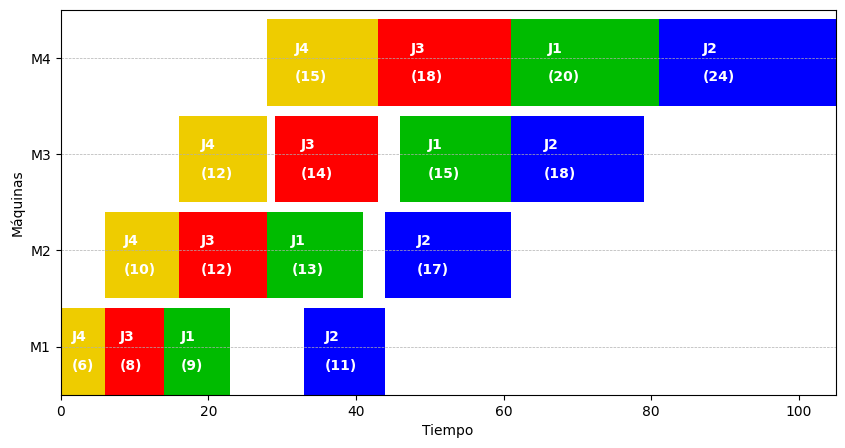

In [15]:
import gurobipy as gp
import matplotlib.pyplot as plt
import numpy as np

T = np.array([[9, 13, 15, 20],
              [11, 17, 18, 24],
              [8, 12, 14, 18],
              [6, 10, 12, 15]])

T = T.transpose()

# Crear el modelo
model = gp.Model("Wagner_Model")

N = len(T[0])  # Numero de tareas
M = len(T)     # Numero de maquinas

# Definir las variables
Z = model.addVars(N, N, vtype=gp.GRB.BINARY, name="Z")
X = model.addVars(M, N, vtype=gp.GRB.INTEGER, lb=0, name="X")
Y = model.addVars(M, N, vtype=gp.GRB.INTEGER, lb=0, name="Y")

# Definir la función objetivo
model.setObjective(gp.quicksum(T[M-1][i] for i in range(N)) +
                   gp.quicksum(X[M-1, p] for p in range(N)), gp.GRB.MINIMIZE)

# Definir las restricciones
for i in range(N):
    model.addConstr(gp.quicksum(Z[i, j] for j in range(N)) == 1)
    
for j in range(N):
    model.addConstr(gp.quicksum(Z[i, j] for i in range(N)) == 1)

for r in range(M - 1):
    for j in range(N - 1):
        model.addConstr(gp.quicksum(T[r][i] * Z[i,j+1] for i in range(N)) -
                        gp.quicksum(T[r+1][i] * Z[i,j] for i in range(N)) +
                        X[r,j+1] - X[r+1,j+1] + Y[r,j+1] - Y[r,j] == 0)

for r in range(M - 1):
    model.addConstr(gp.quicksum(T[r][i] * Z[i,0] for i in range(N)) +
                    X[r,0] - X[r+1,0] + Y[r,0] == 0)

# Resolver el problema
model.setParam('OutputFlag', False)
model.optimize()

# Imprimir la solución
print("Objective Value:", model.objVal)

# Carta Gannt
# Determinar el orden de las tareas
unos_tareas = [(i, j) for i in range(N) for j in range(N) if Z[i, j].x == 1]
orden_tareas = [tupla[0] for tupla in sorted(unos_tareas, key=lambda x: x[1])]

# Matriz de tiempos
matriz = []
for r in range(M):
    maquina = []
    for j in range(N):
        if(j == 0):
            maquina.append([int(X[r, j].x), int(X[r, j].x) + T[r][orden_tareas[j]]])
        else:
            maquina.append([maquina[-1][1]+int(X[r, j].x), maquina[-1][1] + int(X[r, j].x) + T[r][orden_tareas[j]]])
    matriz.append(maquina)

# Graficar la carta de Gantt
fig, gantt = plt.subplots(figsize=(10, 5))
gantt.set_xlabel('Tiempo')
gantt.set_ylabel('Máquinas')
gantt.set_xlim(0, model.objVal)
gantt.set_ylim(0, M * 10)
gantt.set_yticks(np.arange(5, M * 10, 10))
gantt.set_yticklabels(['M' + str(i) for i in range(1, M+1)])
gantt.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)
colores = ['#00BB00', 'blue', 'red', '#EECC00']

for r in range(M):
    for j in range(N):
        inicio = matriz[r][j][0]
        duracion = matriz[r][j][1] - matriz[r][j][0]
        gantt.broken_barh([(inicio, duracion)], ((r) * 10, 9), facecolors=colores[orden_tareas[j]])
        gantt.text(x=(inicio + duracion/4), y=((r) * 10 + 6), s='J'+str(orden_tareas[j]+1), va='center', color='white', fontweight='bold')
        gantt.text(x=(inicio + duracion/4), y=((r) * 10 + 3), s='('+str(duracion)+')', va='center', color='white', fontweight='bold')

